In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [3]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image


Define Agent

In [4]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature = 0,
    groq_api_key = "API_KEY",
    model_name = "llama-3.3-70b-versatile"
)


In [7]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system","You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human","Create an itinerary for my day trip."),
])


Define Agent Function

In [8]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter your destination: ")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }

def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please enter nearby places you also want to visit: {state['city']} (comma-separated):  ")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating your itinerary for {state['city']} based on your interests : {', '.join(state['interests'])} ")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'],interests=', '.join(state['interests'])))
    print("\nHooray!! Your itinerary is generated, enjoy your trip : ")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

In [9]:
workflow = StateGraph(PlannerState)
workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()


Display the graph structure

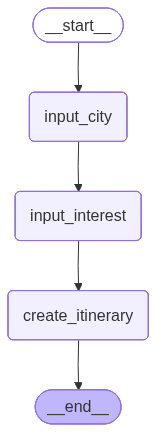

In [10]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

Define the function that runs the graph

In [11]:
def travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")

    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }
    for output in app.stream(state):
        pass


In [12]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter your destination: 
Your Input: Haridwar
Please enter nearby places you also want to visit: Haridwar (comma-separated):  
Your Input: rishikesh
Creating your itinerary for Haridwar based on your interests : rishikesh 

Hooray!! Your itinerary is generated, enjoy your trip : 
Since you're interested in Rishikesh, I've created a day trip itinerary for Haridwar that includes a visit to Rishikesh. Here's a brief, bulleted itinerary:

* 8:00 AM: Start the day with a visit to Har Ki Pauri in Haridwar for a spiritual morning experience
* 10:00 AM: Drive to Rishikesh (approximately 30 minutes) and visit the iconic Lakshman Jhula
* 12:00 PM: Explore the Ram Jhula and surrounding market area
* 1:30 PM: Take a break for lunch at one of the local restaurants in Rishikesh
* 3:00 PM: Visit the Triveni Ghat in Rishikesh for a scenic view of the Ganges River
* 5:00 PM: Return to Haridwar and visit the Mansa Devi Temple
* 7:00 PM: End the day with

In [13]:
!pip install gradio

In [ ]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str


llm = ChatGroq(
    temperature=0,
    groq_api_key="API_KEY",
    model_name="llama-3.3-70b-versatile"
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system","You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human","Create an itinerary for my day trip."),
])


def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }


def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }


def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(
        itinerary_prompt.format_messages(
            city=state['city'],
            interests=', '.join(state['interests'])
        )
    )
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content


def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary


interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary", lines=15),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary. "
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b9a57c002dbaf83fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
